## Binary classification comparison pipeline
### SVM: RBF Kernel classifier, nested cross-validation, y-stratified data:

Compares 4 ways of balancing our imbalanced y-class data (white wines >> reds) using the following strategies:
1) Plain (data as-is)
2) Balanced: reweights classes inversely proportional to their prevalence
3) Undersampled: undersamples datapoints in dominant class to match number of underrepresented datapoints
4) SMOTE: oversamples by taking random points along the direction of one of the k nearest neighbors of the actual data points in the feature space.

The analysis pipeline uses nested cross validation: instead of initially splitting the dataset just once into a train and test set and then performing hyperparameter tuning using CV on the training set, finally evaluating the selected hyperparameters on the single held out test set, the initial train-test split is in itself performed k times in an outer k-fold CV loop. In each rotation, an inner CV loop is executed to tune the hyperparameters. Finally, the average performance metrics of the outer CV loop on the model is reported. 

This minimized data leakage and bias from the hyperparameter tuning, which is essential when the purpose is benchmarking the model against other methods (in our case against NNs.)


Running nested CV for: Plain...
Running nested CV for: Balanced...
Running nested CV for: Undersampled...
Running nested CV for: SMOTE...
              Accuracy  Precision (red)  Recall (red)  F1 (red)  Macro F1  \
Model                                                                       
Plain            0.980            0.965         0.952     0.958     0.973   
Balanced         0.979            0.956         0.959     0.958     0.972   
Undersampled     0.962            0.908         0.939     0.923     0.949   
SMOTE            0.978            0.956         0.953     0.954     0.970   

              ROC-AUC  Brier  Most Common C Most Common gamma  \
Model                                                           
Plain           0.992  0.018            100              0.01   
Balanced        0.991  0.018            100              0.01   
Undersampled    0.986  0.033            100             scale   
SMOTE           0.991  0.019            100              0.01   

        

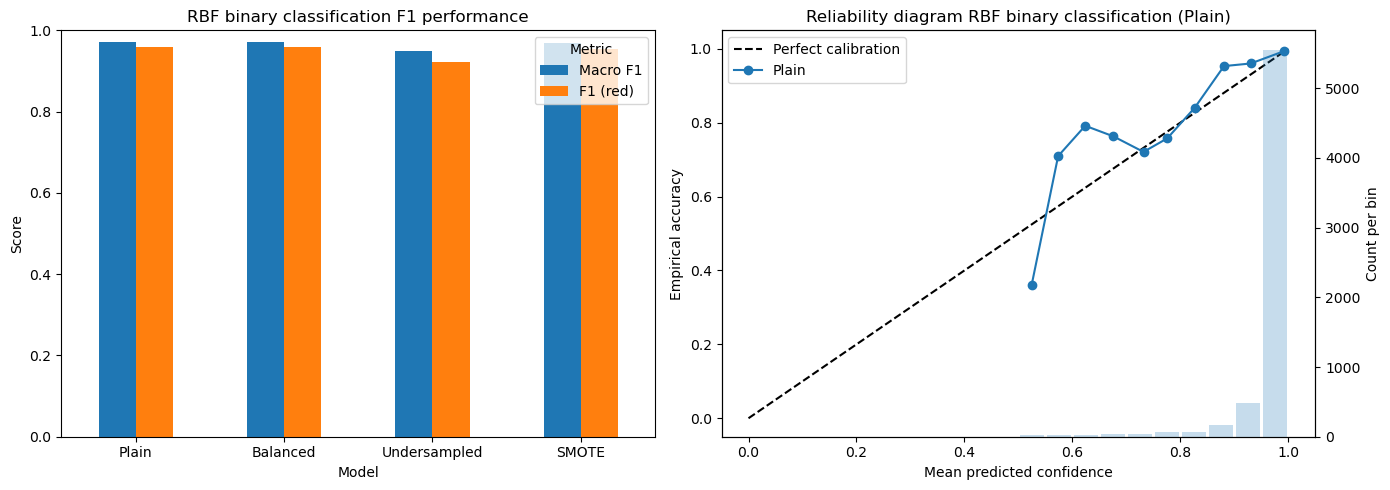

In [11]:
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

df = pd.read_csv("wine_quality_merged.csv")

# --- 1. Read df and encode labels ---
X = df.drop(['type','quality'], axis=1)
y = df['type']
y_num = y.map({"red": 1, "white": 0})

# --- 2. Define scorers ---
scorers = {
    "accuracy": make_scorer(accuracy_score),
    "precision": make_scorer(precision_score, pos_label=1),
    "recall": make_scorer(recall_score, pos_label=1),
    "f1_red": make_scorer(f1_score, pos_label=1),
    "macro_f1": make_scorer(f1_score, average="macro"),
    "roc_auc": make_scorer(roc_auc_score, response_method="predict_proba")
}

# --- 3. Define parameter grid ---
param_grid = {
    "svc__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "svc__gamma": ["scale", 0.1, 0.01],
    "svc__kernel": ["rbf"]
}

# --- 4. Define models ---
pipelines = {
    "Plain": Pipeline([("svc", SVC(probability=True, random_state=42))]),
    "Balanced": Pipeline([("svc", SVC(probability=True, class_weight="balanced", random_state=42))]),
    "Undersampled": Pipeline([
        ("under", RandomUnderSampler(random_state=42)),
        ("svc", SVC(probability=True, random_state=42))
    ]),
    "SMOTE": Pipeline([
        ("smote", SMOTE(random_state=42)),
        ("svc", SVC(probability=True, random_state=42))
    ])
}

# --- 5. Outer & Inner CV ---
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)

results = []

def get_mode(lst):
    if not lst:
        return None
    counter = Counter(lst)
    return counter.most_common(1)[0][0]

for name, pipe in pipelines.items():
    print(f"Running nested CV for: {name}...")
    best_params_list = []
    c_list = []
    gamma_list = []
    outer_scores = []

    for train_idx, test_idx in outer_cv.split(X, y_num):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y_num.iloc[train_idx], y_num.iloc[test_idx]

        grid = GridSearchCV(
            estimator=clone(pipe),
            param_grid=param_grid,
            scoring="f1_macro",
            cv=inner_cv,
            n_jobs=-1
        )
        grid.fit(X_train, y_train)
        best_params = grid.best_params_
        c_val = best_params["svc__C"]
        gamma_val = best_params["svc__gamma"]
        c_list.append(c_val)
        gamma_list.append(gamma_val)

        # Get the actual SVC estimator (handle imblearn pipeline)
        svc_est = grid.best_estimator_
        if hasattr(svc_est, "named_steps"):
            svc = svc_est.named_steps["svc"]
        else:
            svc = svc_est

        # Format gamma for display
        if gamma_val == "scale":
            n_features = X_train.shape[1]
            X_var = X_train.var().mean()
            scale_value = 1.0 / (n_features * X_var) if X_var > 0 else np.nan
            gamma_str = f"gamma: scale = {scale_value:.5g}"
        else:
            gamma_str = f"gamma: {gamma_val}"

        params_str = f"C: {c_val}, {gamma_str}"
        best_params_list.append(params_str)

        y_pred = grid.predict(X_test)
        proba = grid.predict_proba(X_test)[:, 1] 
        brier_fold = np.mean((proba - y_test.values) ** 2)
        
        outer_scores.append({
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred, pos_label=1),
            "recall": recall_score(y_test, y_pred, pos_label=1),
            "f1_red": f1_score(y_test, y_pred, pos_label=1),
            "macro_f1": f1_score(y_test, y_pred, average="macro"),
            "roc_auc": roc_auc_score(y_test, grid.predict_proba(X_test)[:,1]), 
            "brier": brier_fold,
        })

    # Aggregate metrics
    avg_scores = {metric: np.mean([fold[metric] for fold in outer_scores]) for metric in outer_scores[0]}
    params_str_all = "; ".join(best_params_list)
    most_common_c = get_mode(c_list)
    most_common_gamma = get_mode(gamma_list)

    results.append({
        "Model": name,
        "Accuracy": avg_scores["accuracy"],
        "Precision (red)": avg_scores["precision"],
        "Recall (red)": avg_scores["recall"],
        "F1 (red)": avg_scores["f1_red"],
        "Macro F1": avg_scores["macro_f1"],
        "ROC-AUC": avg_scores["roc_auc"],
        "Brier": avg_scores["brier"],   
        "Most Common C": most_common_c,
        "Most Common gamma": most_common_gamma,
        "Best Params (per fold)": params_str_all
    })

df_results = pd.DataFrame(results).set_index("Model")
pd.set_option("display.precision", 3)
print(df_results)

# Select best strategy according to Macro F1
best_name = df_results["Macro F1"].idxmax()
print(f"Best strategy: {best_name}")

best_pipe = pipelines[best_name]

# Re-run outer CV only for the best strategy and collect OOF probabilities
y_true_all = []
p_pos_all  = []
best_params_per_fold = []

for train_idx, test_idx in outer_cv.split(X, y_num):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_num.iloc[train_idx], y_num.iloc[test_idx]

    grid = GridSearchCV(
        estimator=clone(best_pipe),
        param_grid=param_grid,
        scoring="f1_macro",
        cv=inner_cv,
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    best_params_per_fold.append(grid.best_params_)

    # Probabilities for positive class = 1
    p_pos = grid.predict_proba(X_test)[:, 1]

    y_true_all.append(y_test.to_numpy())
    p_pos_all.append(p_pos)

y_true_all = np.concatenate(y_true_all)
p_pos_all  = np.concatenate(p_pos_all)

# Create two-column probabilities: [P(y=0), P(y=1)]
y_proba_bin = np.column_stack([1.0 - p_pos_all, p_pos_all])

# Bin construction for reliability: use top-class confidence and correctness
conf = y_proba_bin.max(axis=1)                # predicted top-class probability
pred = y_proba_bin.argmax(axis=1)             # predicted class
acc  = (pred == y_true_all).astype(float)     # 1 if correct, else 0

n_bins = 20
bins = np.linspace(0.0, 1.0, n_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

bin_counts = np.zeros(n_bins, dtype=int)
bin_conf   = np.full(n_bins, np.nan)
bin_acc    = np.full(n_bins, np.nan)

for i in range(n_bins):
    m = (conf > bins[i]) & (conf <= bins[i + 1])
    if np.any(m):
        bin_counts[i] = m.sum()
        bin_conf[i]   = conf[m].mean()
        bin_acc[i]    = acc[m].mean()

# Filter out empty bins
mask = ~np.isnan(bin_conf)
centers_nonempty = bin_centers[mask]
counts_nonempty  = bin_counts[mask]
bin_conf_plot    = bin_conf[mask]
bin_acc_plot     = bin_acc[mask]

# --- Combined figure: F1 bars + reliability ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: F1 performance
cols_to_plot = [c for c in ["Macro F1", "F1 (red)"] if c in df_results.columns]
df_results[cols_to_plot].plot(kind="bar", ax=axes[0])
axes[0].set_title("RBF binary classification F1 performance")
axes[0].set_ylabel("Score")
axes[0].set_ylim(0, 1)
axes[0].set_xticks(range(len(df_results.index)))
axes[0].set_xticklabels(df_results.index, rotation=0)
axes[0].legend(title="Metric")

# Right: Reliability diagram
ax = axes[1]
ax.plot([0, 1], [0, 1], "k--", label="Perfect calibration")
ax.plot(bin_conf_plot, bin_acc_plot, marker="o", label=best_name)
ax.set_xlabel("Mean predicted confidence")
ax.set_ylabel("Empirical accuracy")
ax.set_title(f"Reliability diagram RBF binary classification ({best_name})")

ax2 = ax.twinx()
bar_w = 0.9 * (bins[1] - bins[0])
ax2.bar(centers_nonempty, counts_nonempty, width=bar_w, alpha=0.25)
ax2.set_ylabel("Count per bin")

ax.legend(loc="upper left")
plt.tight_layout()
plt.show()

# Export results to LaTeX table
with open("df_results_binary_rbf.tex", "w") as f:
   f.write(df_results.to_latex(float_format="%.3f"))

## Binary classification
### Neural network

Running nested CV for: Plain...
Running nested CV for: Balanced...
Running nested CV for: Undersampled...
Running nested CV for: SMOTE...
              Accuracy  Precision (red)  Recall (red)  F1 (red)  Macro F1  \
Model                                                                       
Plain            0.980            0.981         0.936     0.958     0.972   
Balanced         0.980            0.946         0.974     0.959     0.973   
Undersampled     0.970            0.923         0.960     0.940     0.960   
SMOTE            0.981            0.957         0.968     0.962     0.975   

              ROC-AUC  Brier  Most Common lr  Most Common epochs  \
Model                                                              
Plain           0.993  0.017            0.01                  40   
Balanced        0.994  0.017            0.01                  40   
Undersampled    0.992  0.024            0.01                  40   
SMOTE           0.993  0.015            0.01               

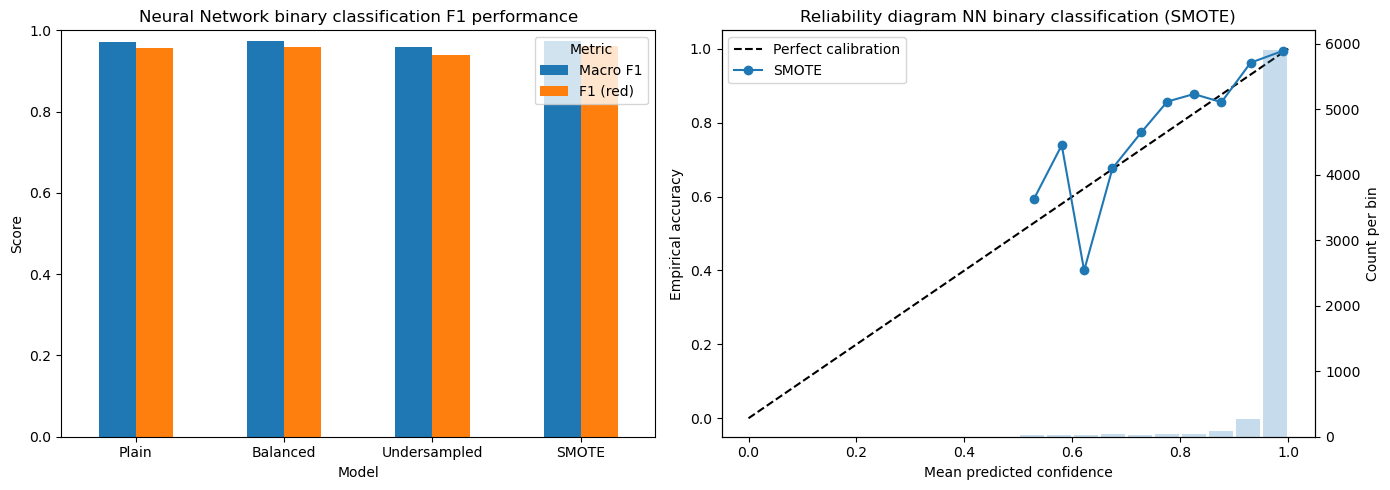

In [12]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from skorch import NeuralNetClassifier

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer
from sklearn.preprocessing import FunctionTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import matplotlib.pyplot as plt

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

df = pd.read_csv("wine_quality_merged.csv")

# ======================
# 1. Define dataset
# ======================
X = df.drop(['type','quality'], axis=1)
y = df['type'].map({"red": 1, "white": 0})  # binary labels

# ======================
# 2. Define NN model
# ======================
class SimpleBinaryNN(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.fc1 = nn.Linear(num_features, 32)
        self.fc2 = nn.Linear(32, 16)
        self.out = nn.Linear(16, 2)  # 2 outputs for binary softmax

    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        return self.out(X)

num_features = X.shape[1]

# ======================
# 3. Scorers
# ======================
scorers = {
    "accuracy": make_scorer(accuracy_score),
    "precision": make_scorer(precision_score, pos_label=1),
    "recall": make_scorer(recall_score, pos_label=1),
    "f1_red": make_scorer(f1_score, pos_label=1),
    "macro_f1": make_scorer(f1_score, average="macro"),
    "roc_auc": make_scorer(roc_auc_score, response_method="predict_proba"),
}

# ======================
# 4. NeuralNet wrapper
# ======================
base_net = NeuralNetClassifier(
    module=SimpleBinaryNN,
    module__num_features=num_features,
    max_epochs=20,
    lr=0.01,
    optimizer=torch.optim.Adam,
    criterion=nn.CrossEntropyLoss,
    iterator_train__shuffle=True,
    verbose=0,
    device="cpu"
)

# ======================
# 5. Param grid for GridSearchCV
# ======================
param_grid = {
    "net__lr": [0.01, 0.001],
    "net__max_epochs": [20, 40],
}

# ======================
# 6. Define pipelines (Plain / Balanced / Under / SMOTE)
# ======================
to_numpy = FunctionTransformer(
    lambda x: x.to_numpy(dtype=np.float32) if hasattr(x, "to_numpy") else x.astype(np.float32)
)

pipelines = {
    "Plain": Pipeline([
        ("to_numpy", to_numpy),
        ("net", base_net),
    ]),
    "Balanced": Pipeline([
        ("to_numpy", to_numpy),
        ("net", NeuralNetClassifier(
            module=SimpleBinaryNN,
            module__num_features=num_features,
            max_epochs=20,
            lr=0.01,
            optimizer=torch.optim.Adam,
            criterion=nn.CrossEntropyLoss,
            iterator_train__shuffle=True,
            verbose=0,
            device="cpu",
            train_split=None,
            # simulate balancing with weighted loss
            criterion__weight=torch.tensor([1.0, float(sum(y==0))/sum(y==1)], dtype=torch.float32)
        ))
    ]),
    "Undersampled": Pipeline([
        ("under", RandomUnderSampler(random_state=SEED)),
        ("to_numpy", to_numpy),
        ("net", base_net),
    ]),
    "SMOTE": Pipeline([
        ("smote", SMOTE(random_state=SEED)),
        ("to_numpy", to_numpy),
        ("net", base_net),
    ]),
}

# ======================
# 7. Nested CV
# ======================
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

results = []

def get_mode(lst):
    counter = Counter(lst)
    return counter.most_common(1)[0][0] if lst else None

def prettify_params(params_dict):
    """Convert {'net__lr': 0.01, 'net__max_epochs': 40} into 'lr=0.01, max_epochs=40'."""
    pretty = []
    for k, v in params_dict.items():
        key = k.replace("net__", "")
        pretty.append(f"{key}={v}")
    return ", ".join(pretty)

for name, pipe in pipelines.items():
    print(f"Running nested CV for: {name}...")
    best_params_list = []
    lr_list = []
    epoch_list = []
    outer_scores = []

    for train_idx, test_idx in outer_cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        grid = GridSearchCV(
            estimator=pipe,
            param_grid=param_grid,
            scoring="f1_macro",
            cv=inner_cv,
            n_jobs=-1
        )
        grid.fit(X_train, y_train)

        best_params = grid.best_params_
        lr_val = best_params.get("net__lr", None)
        ep_val = best_params.get("net__max_epochs", None)
        lr_list.append(lr_val)
        epoch_list.append(ep_val)

        y_pred = grid.predict(X_test)
        y_proba = grid.predict_proba(X_test)[:,1]
        brier_fold = np.mean((y_proba - y_test.values) ** 2)

        outer_scores.append({
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred, pos_label=1),
            "recall": recall_score(y_test, y_pred, pos_label=1),
            "f1_red": f1_score(y_test, y_pred, pos_label=1),
            "macro_f1": f1_score(y_test, y_pred, average="macro"),
            "roc_auc": roc_auc_score(y_test, y_proba), 
            "brier": brier_fold
        })

        best_params_str = prettify_params(best_params)
        best_params_list.append(best_params_str)

    avg_scores = {metric: np.mean([fold[metric] for fold in outer_scores]) for metric in outer_scores[0]}
    results.append({
        "Model": name,
        "Accuracy": avg_scores["accuracy"],
        "Precision (red)": avg_scores["precision"],
        "Recall (red)": avg_scores["recall"],
        "F1 (red)": avg_scores["f1_red"],
        "Macro F1": avg_scores["macro_f1"],
        "ROC-AUC": avg_scores["roc_auc"],
        "Brier": avg_scores["brier"],
        "Most Common lr": get_mode(lr_list),
        "Most Common epochs": get_mode(epoch_list),
        "Best Params (per fold)": "; ".join(best_params_list)
    })

df_results = pd.DataFrame(results).set_index("Model")
pd.set_option("display.precision", 3)
print(df_results)
print("\nBrier score per strategy:")
print(df_results["Brier"])


# Select best strategy according to Macro F1
best_name = df_results["Macro F1"].idxmax()
print(f"Best strategy: {best_name}")

best_pipe = pipelines[best_name]

# Re-run outer CV only for the best strategy and collect out-of-fold probabilities
y_true_all = []
p_pos_all  = []
best_params_per_fold = []

for train_idx, test_idx in outer_cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    grid = GridSearchCV(
        estimator=best_pipe,
        param_grid=param_grid,
        scoring="f1_macro",
        cv=inner_cv,
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    best_params_per_fold.append(grid.best_params_)

    # Probability for positive class = 1
    y_proba = grid.predict_proba(X_test)          # shape n x 2 from skorch softmax
    p_pos   = y_proba[:, 1]

    y_true_all.append(y_test.to_numpy())
    p_pos_all.append(p_pos)

y_true_all = np.concatenate(y_true_all)
p_pos_all  = np.concatenate(p_pos_all)

# Two columns with probabilities [P(y=0), P(y=1)]
y_proba_bin = np.column_stack([1.0 - p_pos_all, p_pos_all])

# Reliability diagram for top class
conf = y_proba_bin.max(axis=1)          # predicted top-class probability
pred = y_proba_bin.argmax(axis=1)       # predicted class
acc  = (pred == y_true_all).astype(float)

n_bins = 20
bins = np.linspace(0.0, 1.0, n_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

bin_counts = np.zeros(n_bins, dtype=int)
bin_conf   = np.full(n_bins, np.nan)
bin_acc    = np.full(n_bins, np.nan)

for i in range(n_bins):
    m = (conf > bins[i]) & (conf <= bins[i + 1])
    if np.any(m):
        bin_counts[i] = m.sum()
        bin_conf[i]   = conf[m].mean()
        bin_acc[i]    = acc[m].mean()

mask = ~np.isnan(bin_conf)
centers_nonempty = bin_centers[mask]
counts_nonempty  = bin_counts[mask]
bin_conf_plot    = bin_conf[mask]
bin_acc_plot     = bin_acc[mask]

# ======================
# 8. Combined figure: performance + reliability
# ======================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left panel: F1 performance
cols_to_plot = [c for c in ["Macro F1", "F1 (red)"] if c in df_results.columns]
df_results[cols_to_plot].plot(kind="bar", ax=axes[0])
axes[0].set_title("Neural Network binary classification F1 performance")
axes[0].set_ylabel("Score")
axes[0].set_ylim(0, 1)
axes[0].set_xticks(range(len(df_results.index)))
axes[0].set_xticklabels(df_results.index, rotation=0)
axes[0].legend(title="Metric")

# Right panel: Reliability diagram
ax = axes[1]
ax.plot([0, 1], [0, 1], "k--", label="Perfect calibration")
ax.plot(bin_conf_plot, bin_acc_plot, marker="o", label=best_name)
ax.set_xlabel("Mean predicted confidence")
ax.set_ylabel("Empirical accuracy")
ax.set_title(f"Reliability diagram NN binary classification ({best_name})")

ax2 = ax.twinx()
bar_w = 0.9 * (bins[1] - bins[0])
ax2.bar(centers_nonempty, counts_nonempty, width=bar_w, alpha=0.25)
ax2.set_ylabel("Count per bin")

ax.legend(loc="upper left")
plt.tight_layout()
plt.show()

# Export results to LaTeX table
with open("df_results_binary_nn.tex", "w") as f:
   f.write(df_results.to_latex(float_format="%.3f"))